In [ ]:
try:
    import open_clip
    from optim_utils import * 
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import open_clip
    from optim_utils import * 

import torch
from torchvision import transforms
import mediapy as media
import argparse

## Load Arguments

In [2]:
args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))
args

Namespace(prompt_len=16, iter=3000, lr=0.1, weight_decay=0.1, prompt_bs=1, loss_weight=1.0, print_step=100, batch_size=1, clip_model='ViT-H-14', clip_pretrain='laion2b_s32b_b79k')

## Load Clip Model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

## Load Diffusion Model

In [4]:
from diffusers import DPMSolverMultistepScheduler
from modified_stable_diffusion_pipeline import ModifiedStableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

weight_dtype = torch.float32

pipe = ModifiedStableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=weight_dtype,
    revision="fp16",
    )
pipe = pipe.to(device)

pipe.vae.requires_grad_(False)
pipe.unet.requires_grad_(True)
pipe.unet.train()

image_length = 512

tokenizer = pipe.tokenizer
token_embedding = pipe.text_encoder.text_model.embeddings.token_embedding

preprocess = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
    ]
)

Error caught was: No module named 'triton'
Fetching 12 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1274.77it/s]


## Load Target Image


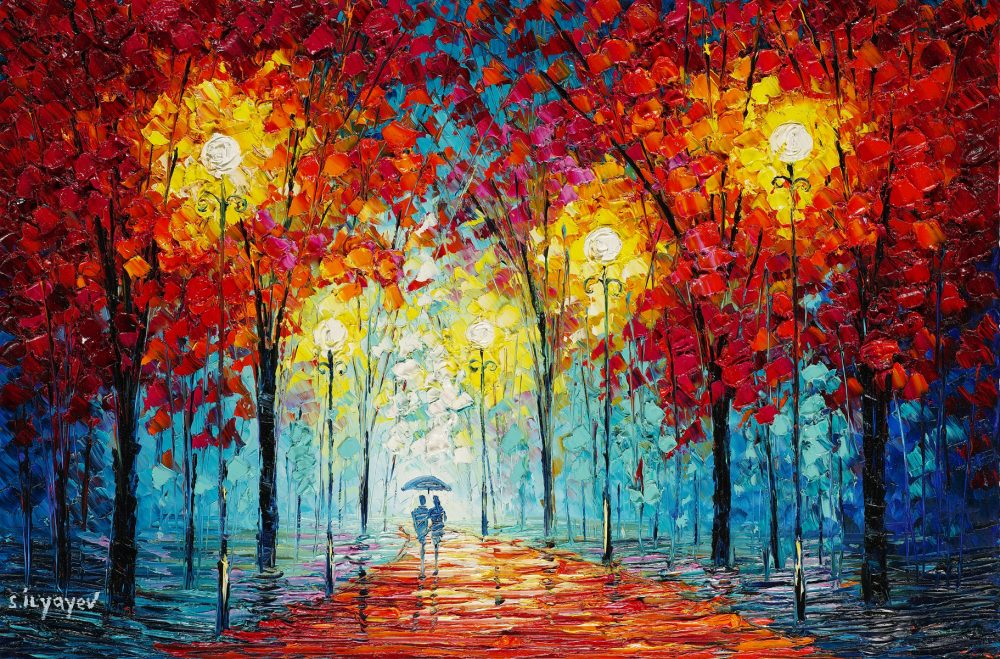

In [5]:
urls = [
        "https://www.parkwestgallery.com/wp-content/uploads/2017/10/im811243-e1507918728745.jpg",
       ]

orig_images = list(filter(None,[download_image(url) for url in urls]))
media.show_images(orig_images)

In [6]:
# image to latent space
with torch.no_grad():
    curr_images = [preprocess(i).unsqueeze(0) for i in orig_images]
    curr_images = torch.concatenate(curr_images).to(device)
    all_latents = pipe.vae.encode(curr_images.to(weight_dtype)).latent_dist.sample()
    all_latents = all_latents * 0.18215

## Optimize Prompt

In [7]:
args.prompt_len = 8

args.opt_iters = 1000
args.eval_step = 50

In [8]:
prompt_embeds, dummy_embeds, dummy_ids = initialize_prompt(tokenizer, token_embedding, args, device)

In [9]:
input_optimizer = torch.optim.AdamW([prompt_embeds], lr=args.lr, weight_decay=args.weight_decay)
input_optim_scheduler = None

best_loss = -999
eval_loss = -99999
best_text = ""
best_embeds = None

for step in range(args.opt_iters):
    # forward projection
    projected_embeds, nn_indices = nn_project(prompt_embeds, token_embedding)
    tmp_embeds = copy.deepcopy(prompt_embeds)
    tmp_embeds.data = projected_embeds.data
    tmp_embeds.requires_grad = True
        
    # padding and repeat
    padded_embeds = copy.deepcopy(dummy_embeds)
    padded_embeds[:, 1:args.prompt_len+1] = tmp_embeds
    padded_embeds = padded_embeds.repeat(args.batch_size, 1, 1)
    padded_dummy_ids = dummy_ids.repeat(args.batch_size, 1)
    
    # randomly sample sample images and get features
    if args.batch_size is None:
        latents = all_latents
    else:
        perm = torch.randperm(len(all_latents))
        idx = perm[:args.batch_size]
        latents = all_latents[idx]
        
    # Sample noise that we'll add to the latents
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # Sample a random timestep for each image
    timesteps = torch.randint(0, 1000, (bsz,), device=latents.device)
    timesteps = timesteps.long()
        
    # Add noise to the latents according to the noise magnitude at each timestep
    noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

    # Get the target for loss depending on the prediction type
    if pipe.scheduler.config.prediction_type == "epsilon":
        target = noise
    elif pipe.scheduler.config.prediction_type == "v_prediction":
        target = pipe.scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {pipe.scheduler.config.prediction_type}")
        
    # get text embeddings
    text_embeddings = pipe._get_text_embedding_with_embeddings(padded_dummy_ids, padded_embeds)
    
    # Predict the noise residual and compute loss
    model_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
    loss = torch.nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")
    
    ### update prompt
    prompt_embeds.grad, = torch.autograd.grad(loss, [tmp_embeds])
    input_optimizer.step()
    input_optimizer.zero_grad()    
    
    curr_lr = input_optimizer.param_groups[0]["lr"]
    
    ### eval
    if step % args.eval_step == 0:
        decoded_text = decode_ids(nn_indices, tokenizer)[0]
        print(f"step: {step}, lr: {curr_lr}, cosim: {eval_loss:.3f}, best_cosim: {best_loss:.3f}, best prompt: {best_text}")
            
        with torch.no_grad():
            pred_imgs = pipe(
                decoded_text,
                num_images_per_prompt=4,
                guidance_scale=9,
                num_inference_steps=25,
                height=image_length,
                width=image_length,
                ).images
            eval_loss = measure_similarity(orig_images, pred_imgs, clip_model, clip_preprocess, device)

        if best_loss < eval_loss:
            best_loss = eval_loss
            best_text = decoded_text
            best_embeds = copy.deepcopy(prompt_embeds.detach())    
            
print()
print(f"Best shot: consine similarity: {best_loss:.3f}")
print(f"text: {best_text}")

step: 0, lr: 0.1, cosim: -99999.000, best_cosim: -999.000, best prompt: 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.12it/s]


step: 50, lr: 0.1, cosim: 0.183, best_cosim: 0.183, best prompt: ek nachos bound nyt getic doomsday mechanisms thri


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.10it/s]


step: 100, lr: 0.1, cosim: 0.319, best_cosim: 0.319, best prompt: starry neurons ctions snatched gdpr trends chloe.,


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.10it/s]


step: 150, lr: 0.1, cosim: 0.345, best_cosim: 0.345, best prompt: huff neurons terrible popular usual hoywidoleaves


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 200, lr: 0.1, cosim: 0.369, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 250, lr: 0.1, cosim: 0.113, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 300, lr: 0.1, cosim: 0.217, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 350, lr: 0.1, cosim: 0.249, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 400, lr: 0.1, cosim: 0.177, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 450, lr: 0.1, cosim: 0.267, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 500, lr: 0.1, cosim: 0.088, best_cosim: 0.369, best prompt: quietestimate apologize canoe keepatmosilent tilt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 550, lr: 0.1, cosim: 0.615, best_cosim: 0.615, best prompt: impressionist impressionism acing udemarch through snowfall parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 600, lr: 0.1, cosim: 0.547, best_cosim: 0.615, best prompt: impressionist impressionism acing udemarch through snowfall parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 650, lr: 0.1, cosim: 0.732, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 700, lr: 0.1, cosim: 0.518, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 750, lr: 0.1, cosim: 0.658, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 800, lr: 0.1, cosim: 0.673, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 850, lr: 0.1, cosim: 0.499, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 900, lr: 0.1, cosim: 0.508, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


step: 950, lr: 0.1, cosim: 0.236, best_cosim: 0.732, best prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]



Best shot: consine similarity: 0.732
text: artgallery artgallery scenery paintings cityscape autumn scenery abstract


## Generate with Stable Diffusion Model

In [10]:
# you can customize the learned prompt here
prompt = best_text

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


prompt: artgallery artgallery scenery paintings cityscape autumn scenery abstract



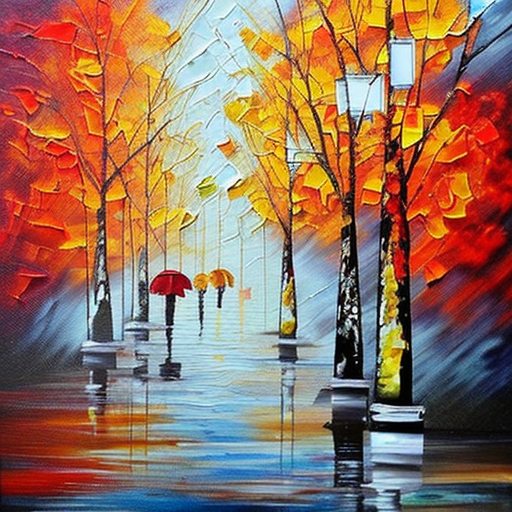
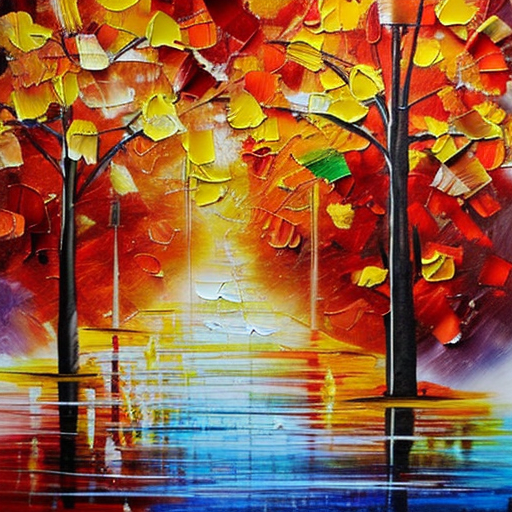
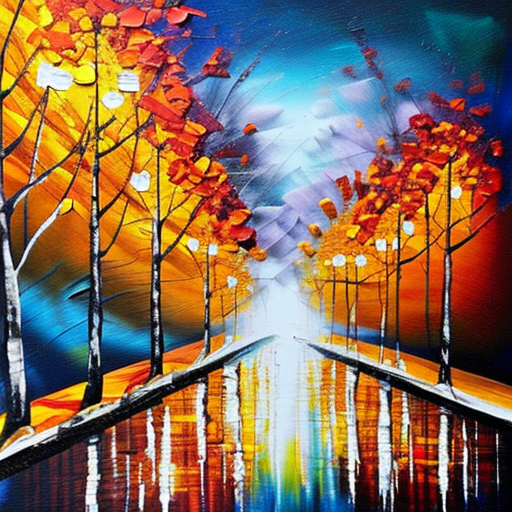
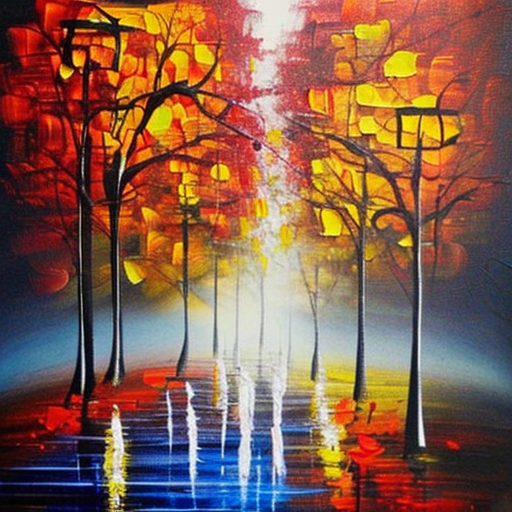

In [11]:
num_images = 4
guidance_scale = 9
num_inference_steps = 25

images = pipe(
    prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)